MCMC‑NF: 100%|██████████| 12000/12000 [01:11<00:00, 166.80it/s, loss=13.2]


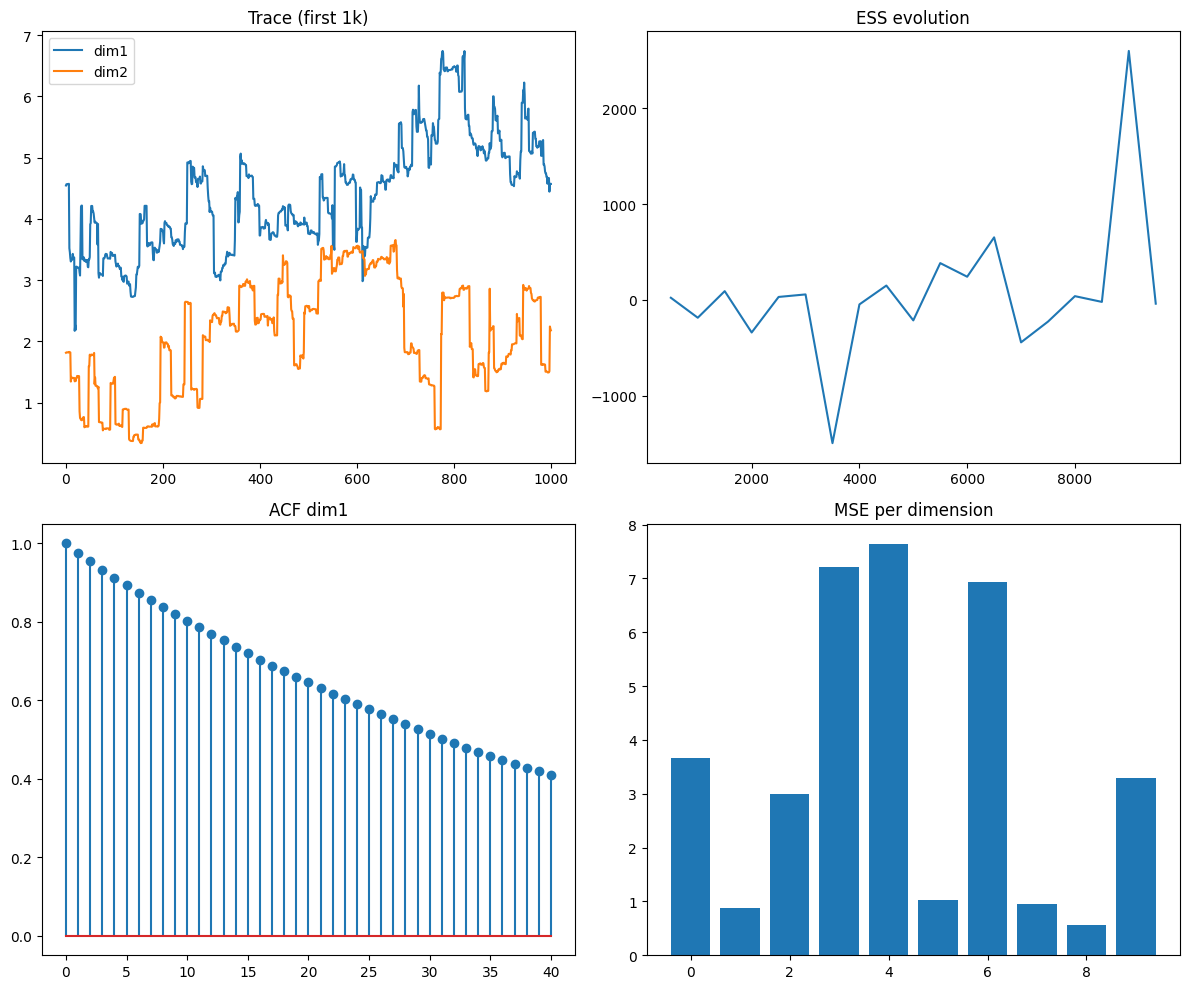


=== Summary ===
Acceptance rate: 80.22%
ESS (avg): -1713.1
Log marginal likelihood: -18.29
Efficiency: -0.1428

Dim 1: MSE = 3.6664
Dim 2: MSE = 0.8864
Dim 3: MSE = 2.9971
Dim 4: MSE = 7.2103
Dim 5: MSE = 7.6329
Dim 6: MSE = 1.0325
Dim 7: MSE = 6.9380
Dim 8: MSE = 0.9475
Dim 9: MSE = 0.5715
Dim 10: MSE = 3.2852


{'samples': array([[ 4.54366779,  1.8134743 , -1.30116534, ..., -2.12713623,
         -0.84905744,  1.26452231],
        [ 4.56462669,  1.81988311, -1.34375572, ..., -2.12472081,
         -0.84475827,  1.77042699],
        [ 4.56462669,  1.81988311, -1.34375572, ..., -2.12472081,
         -0.84475827,  1.77042699],
        ...,
        [ 3.68488669,  3.4108882 , -1.26259685, ..., -1.57568359,
          0.47658619,  1.12239945],
        [ 3.77896881,  3.43319082, -1.29521418, ..., -1.55858397,
          0.44157776,  1.89397013],
        [ 3.77896881,  3.43319082, -1.29521418, ..., -1.55858397,
          0.44157776,  1.89397013]]),
 'ess': <function __main__.ess(samples: numpy.ndarray) -> float>,
 'logml': np.float64(-18.28967987703139),
 'mse': array([3.66640895, 0.88640393, 2.99706224, 7.21031834, 7.63288783,
        1.03251555, 6.93803265, 0.947494  , 0.57149123, 3.28519605]),
 'efficiency': -0.14276027419473733,
 'accept_rate': 0.8021666666666667}

In [3]:
"""
MCMC with Normalizing Flow proposals
"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
from statsmodels.tsa.stattools import acf as sm_acf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Effective Sample Size
def ess(samples: np.ndarray) -> float:
    """Univariate ESS averaged over dimensions."""
    n, d = samples.shape
    ess_dim = []
    for j in range(d):
        rho = sm_acf(samples[:, j], nlags=n // 2, fft=True)
        # sum of autocorr excluding lag 0
        tau = 1 + 2 * np.sum(rho[1:])
        ess_dim.append(n / tau)
    return float(np.mean(ess_dim))


# Synthetic target: 3‑component Gaussian mixture
class TargetDistribution:
    def __init__(self, dim: int):
        self.dim = dim
        self.modes = 3
        self.means = [torch.randn(dim) * 3 for _ in range(self.modes)]
        self.covs = [torch.eye(dim) * (0.5 + torch.rand(dim)) for _ in range(self.modes)]
        self.weights = torch.softmax(torch.rand(self.modes), dim=0)
        self.true_mean = sum(w * m for w, m in zip(self.weights, self.means))

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 1:
            x = x.unsqueeze(0)
        log_ps = []
        for m, S in zip(self.means, self.covs):
            mvn = MultivariateNormal(m.to(x.device), covariance_matrix=S.to(x.device))
            log_ps.append(mvn.log_prob(x))
        log_ps = torch.stack(log_ps, dim=1)
        weighted = log_ps + torch.log(self.weights.to(x.device))
        return torch.logsumexp(weighted, dim=1)


# RealNVP flow with alternating binary masks

class RealNVP(nn.Module):
    def __init__(self, dim, hidden_dim = 64, num_flows = 8):
        super().__init__()
        self.dim = dim
        self.num_flows = num_flows
        # alternating 0/1 masks
        self.masks = [torch.from_numpy(((np.arange(dim) + i) % 2).astype(np.float32))
                       for i in range(num_flows)]
        self.s_nets = nn.ModuleList([
            self._mlp(dim, hidden_dim) for _ in range(num_flows)
        ])
        self.t_nets = nn.ModuleList([
            self._mlp(dim, hidden_dim) for _ in range(num_flows)
        ])

    @staticmethod
    def _mlp(dim, h):
        return nn.Sequential(
            nn.Linear(dim, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, dim)
        )

    def forward(self, z: torch.Tensor):
        log_det = torch.zeros(z.size(0), device=z.device)
        x = z
        for mask, s_net, t_net in zip(self.masks, self.s_nets, self.t_nets):
            mask = mask.to(z.device)
            x_masked = x * mask
            s = s_net(x_masked) * (1 - mask)
            t = t_net(x_masked) * (1 - mask)
            x = x_masked + (1 - mask) * (x * torch.exp(s) + t)
            log_det += torch.sum(s, dim=1)
        return x, log_det

    def inverse(self, x: torch.Tensor):
        log_det = torch.zeros(x.size(0), device=x.device)
        z = x
        for mask, s_net, t_net in reversed(list(zip(self.masks, self.s_nets, self.t_nets))):
            mask = mask.to(x.device)
            z_masked = z * mask
            s = s_net(z_masked) * (1 - mask)
            t = t_net(z_masked) * (1 - mask)
            z = z_masked + (1 - mask) * (z - t) * torch.exp(-s)
            log_det -= torch.sum(s, dim=1)
        return z, log_det

#MCMC with NF

def mcmc_nf(target: TargetDistribution, dim, *, n_samples = 10000,
                burn_in = 2000, lr= 1e-4, block_frac = 0.1,
                step_size = 0.5, device = 'cpu'):
    device = torch.device(device)
    flow = RealNVP(dim).to(device)
    opt = optim.Adam(flow.parameters(), lr=lr)
    base = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))

    total_iters = n_samples + burn_in
    k = max(1, int(block_frac * dim))  # block size

    samples = np.empty((n_samples, dim))
    trace_dim12 = []  # plotting


    z_curr = base.sample()
    x_curr, logdet_curr = flow(z_curr.unsqueeze(0))
    x_curr = x_curr.squeeze(0)
    log_p_curr = target.log_prob(x_curr) + logdet_curr.squeeze(0)

    accept = 0
    pbar = tqdm(range(total_iters), desc='MCMC‑NF')

    for it in pbar:
        # Propose
        z_prop = z_curr.clone()
        idx = torch.randperm(dim, device=device)[:k]
        z_prop[idx] += torch.randn(k, device=device) * step_size

        x_prop, logdet_prop = flow(z_prop.unsqueeze(0))
        x_prop = x_prop.squeeze(0)
        log_p_prop = target.log_prob(x_prop) + logdet_prop.squeeze(0)

        # MH ratio
        log_alpha = (log_p_prop - log_p_curr).item()
        if np.log(np.random.rand()) < log_alpha:
            z_curr, x_curr, log_p_curr = z_prop, x_prop, log_p_prop
            accept += 1

        # store after burn‑in
        if it >= burn_in:
            idx_store = it - burn_in
            samples[idx_store] = x_curr.detach().cpu().numpy()
            if idx_store < 1000:
                trace_dim12.append(x_curr[:2].detach().cpu().numpy())

        # train flow during burn‑in
        if it < burn_in and it % 100 == 0:
            opt.zero_grad()
            z_batch = base.sample((256,))
            x_batch, logdet = flow(z_batch)
            loss = torch.mean(base.log_prob(z_batch) - (target.log_prob(x_batch) + logdet))
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=loss.item())

    accept_rate = accept / total_iters
    ess_samples = ess(samples)
    mse = np.mean((samples - target.true_mean.detach().cpu().numpy()) ** 2, axis=0)
    efficiency = ess_samples / total_iters
    # log marginal likelihood via harmonic mean estimator
    logps = np.array([target.log_prob(torch.from_numpy(s).to(device)).item() for s in samples])
    logml = -np.log(np.mean(np.exp(-logps)))

    #Plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Trace plot dim 1‑2
    trace_arr = np.array(trace_dim12)
    axs[0, 0].plot(trace_arr[:, 0], label='dim1')
    axs[0, 0].plot(trace_arr[:, 1], label='dim2')
    axs[0, 0].set_title('Trace (first 1k)')
    axs[0, 0].legend()

    # ACF dim1
    acorr = sm_acf(samples[:, 0], nlags=40, fft=True)
    axs[1, 0].stem(range(len(acorr)), acorr)
    axs[1, 0].set_title('ACF dim1')

    # ESS evolution
    window = 500
    ess_evol = [ess(samples[:i]) for i in range(window, n_samples, window)]
    axs[0, 1].plot(range(window, n_samples, window), ess_evol)
    axs[0, 1].set_title('ESS evolution')

    # MSE per dim
    axs[1, 1].bar(range(dim), mse)
    axs[1, 1].set_title('MSE per dimension')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== Summary ===")
    print(f"Acceptance rate: {accept_rate:.2%}")
    print(f"ESS (avg): {ess_samples:.1f}")
    print(f"Log marginal likelihood: {logml:.2f}")
    print(f"Efficiency: {efficiency:.4f}\n")
    for j, err in enumerate(mse):
        print(f"Dim {j+1}: MSE = {err:.4f}")

    return dict(samples=samples, ess=ess, logml=logml, mse=mse, efficiency=efficiency,
                accept_rate=accept_rate)


torch.manual_seed(42)
np.random.seed(42)
dimension = 10
target = TargetDistribution(dimension)
mcmc_nf(target, dimension, device='cuda' if torch.cuda.is_available() else 'cpu')


* The results indicate decrease of autocorrelation, so maybe we should have try more iteration.
* ESS gets better with time, but still oscilates too much.
* Trace plot not so expressive, maybe testing more iterations we cam explore more.

MCMC‑NF: 100%|██████████| 17000/17000 [01:47<00:00, 158.69it/s, loss=56.2]


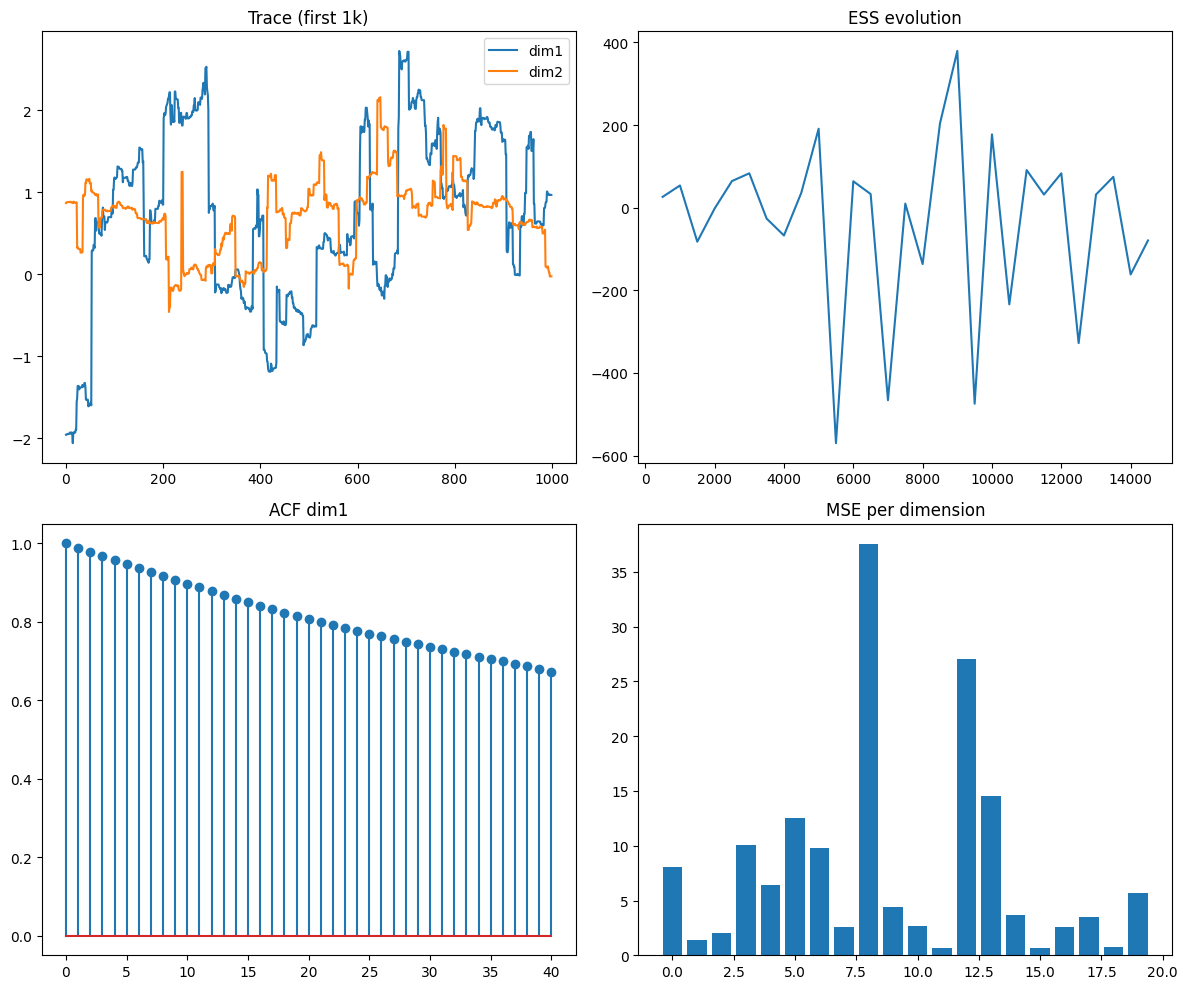


=== Summary ===
Acceptance rate: 71.29%
ESS (avg): 129.0
Log marginal likelihood: -34.84
Efficiency: 0.0076

Dim 1: MSE = 8.0351
Dim 2: MSE = 1.3861
Dim 3: MSE = 2.0580
Dim 4: MSE = 10.0892
Dim 5: MSE = 6.4534
Dim 6: MSE = 12.5449
Dim 7: MSE = 9.7664
Dim 8: MSE = 2.5840
Dim 9: MSE = 37.5128
Dim 10: MSE = 4.4337
Dim 11: MSE = 2.6707
Dim 12: MSE = 0.6688
Dim 13: MSE = 27.0267
Dim 14: MSE = 14.5098
Dim 15: MSE = 3.6881
Dim 16: MSE = 0.6949
Dim 17: MSE = 2.5599
Dim 18: MSE = 3.5308
Dim 19: MSE = 0.7474
Dim 20: MSE = 5.7248


{'samples': array([[-1.95891905,  0.86749089, -0.02802947, ...,  0.69311118,
          0.90432572,  0.60711634],
        [-1.95324683,  0.8771615 , -0.02923186, ...,  0.69475049,
          0.90300763,  0.61637789],
        [-1.95324683,  0.8771615 , -0.02923186, ...,  0.69475049,
          0.90300763,  0.61637789],
        ...,
        [ 1.46721804, -0.47833258,  1.78319466, ...,  3.04822803,
          1.19270098,  0.11157529],
        [ 1.46721804, -0.47833258,  1.78319466, ...,  3.04822803,
          1.19270098,  0.11157529],
        [ 1.50427699, -0.44885144,  1.73037779, ...,  3.01066232,
          1.19622159,  0.13444079]]),
 'ess': <function __main__.ess(samples: numpy.ndarray) -> float>,
 'logml': np.float64(-34.84379540672496),
 'mse': array([ 8.03514188,  1.38612953,  2.0579709 , 10.08916561,  6.45342929,
        12.54488367,  9.7664174 ,  2.58396851, 37.51281201,  4.43374656,
         2.67071666,  0.66884513, 27.02669238, 14.50978269,  3.68806106,
         0.69491608,  2.5598

In [5]:
"""
MCMC with Normalizing Flow proposals
"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
from statsmodels.tsa.stattools import acf as sm_acf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Effective Sample Size
def ess(samples: np.ndarray) -> float:
    """Univariate ESS averaged over dimensions."""
    n, d = samples.shape
    ess_dim = []
    for j in range(d):
        rho = sm_acf(samples[:, j], nlags=n // 2, fft=True)
        # sum of autocorr excluding lag 0
        tau = 1 + 2 * np.sum(rho[1:])
        ess_dim.append(n / tau)
    return float(np.mean(ess_dim))


# Synthetic target: 3‑component Gaussian mixture
class TargetDistribution:
    def __init__(self, dim: int):
        self.dim = dim
        self.modes = 3
        self.means = [torch.randn(dim) * 3 for _ in range(self.modes)]
        self.covs = [torch.eye(dim) * (0.5 + torch.rand(dim)) for _ in range(self.modes)]
        self.weights = torch.softmax(torch.rand(self.modes), dim=0)
        self.true_mean = sum(w * m for w, m in zip(self.weights, self.means))

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 1:
            x = x.unsqueeze(0)
        log_ps = []
        for m, S in zip(self.means, self.covs):
            mvn = MultivariateNormal(m.to(x.device), covariance_matrix=S.to(x.device))
            log_ps.append(mvn.log_prob(x))
        log_ps = torch.stack(log_ps, dim=1)
        weighted = log_ps + torch.log(self.weights.to(x.device))
        return torch.logsumexp(weighted, dim=1)


# RealNVP flow with alternating binary masks

class RealNVP(nn.Module):
    def __init__(self, dim, hidden_dim = 64, num_flows = 8):
        super().__init__()
        self.dim = dim
        self.num_flows = num_flows
        # alternating 0/1 masks
        self.masks = [torch.from_numpy(((np.arange(dim) + i) % 2).astype(np.float32))
                       for i in range(num_flows)]
        self.s_nets = nn.ModuleList([
            self._mlp(dim, hidden_dim) for _ in range(num_flows)
        ])
        self.t_nets = nn.ModuleList([
            self._mlp(dim, hidden_dim) for _ in range(num_flows)
        ])

    @staticmethod
    def _mlp(dim, h):
        return nn.Sequential(
            nn.Linear(dim, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, dim)
        )

    def forward(self, z: torch.Tensor):
        log_det = torch.zeros(z.size(0), device=z.device)
        x = z
        for mask, s_net, t_net in zip(self.masks, self.s_nets, self.t_nets):
            mask = mask.to(z.device)
            x_masked = x * mask
            s = s_net(x_masked) * (1 - mask)
            t = t_net(x_masked) * (1 - mask)
            x = x_masked + (1 - mask) * (x * torch.exp(s) + t)
            log_det += torch.sum(s, dim=1)
        return x, log_det

    def inverse(self, x: torch.Tensor):
        log_det = torch.zeros(x.size(0), device=x.device)
        z = x
        for mask, s_net, t_net in reversed(list(zip(self.masks, self.s_nets, self.t_nets))):
            mask = mask.to(x.device)
            z_masked = z * mask
            s = s_net(z_masked) * (1 - mask)
            t = t_net(z_masked) * (1 - mask)
            z = z_masked + (1 - mask) * (z - t) * torch.exp(-s)
            log_det -= torch.sum(s, dim=1)
        return z, log_det

#MCMC with NF

def mcmc_nf(target: TargetDistribution, dim, *, n_samples = 15000,
                burn_in = 2000, lr= 1e-4, block_frac = 0.1,
                step_size = 0.5, device = 'cpu'):
    device = torch.device(device)
    flow = RealNVP(dim).to(device)
    opt = optim.Adam(flow.parameters(), lr=lr)
    base = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))

    total_iters = n_samples + burn_in
    k = max(1, int(block_frac * dim))  # block size

    samples = np.empty((n_samples, dim))
    trace_dim12 = []  # plotting


    z_curr = base.sample()
    x_curr, logdet_curr = flow(z_curr.unsqueeze(0))
    x_curr = x_curr.squeeze(0)
    log_p_curr = target.log_prob(x_curr) + logdet_curr.squeeze(0)

    accept = 0
    pbar = tqdm(range(total_iters), desc='MCMC‑NF')

    for it in pbar:
        # Propose
        z_prop = z_curr.clone()
        idx = torch.randperm(dim, device=device)[:k]
        z_prop[idx] += torch.randn(k, device=device) * step_size

        x_prop, logdet_prop = flow(z_prop.unsqueeze(0))
        x_prop = x_prop.squeeze(0)
        log_p_prop = target.log_prob(x_prop) + logdet_prop.squeeze(0)

        # MH ratio
        log_alpha = (log_p_prop - log_p_curr).item()
        if np.log(np.random.rand()) < log_alpha:
            z_curr, x_curr, log_p_curr = z_prop, x_prop, log_p_prop
            accept += 1

        # store after burn‑in
        if it >= burn_in:
            idx_store = it - burn_in
            samples[idx_store] = x_curr.detach().cpu().numpy()
            if idx_store < 1000:
                trace_dim12.append(x_curr[:2].detach().cpu().numpy())

        # train flow during burn‑in
        if it < burn_in and it % 100 == 0:
            opt.zero_grad()
            z_batch = base.sample((256,))
            x_batch, logdet = flow(z_batch)
            loss = torch.mean(base.log_prob(z_batch) - (target.log_prob(x_batch) + logdet))
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=loss.item())

    accept_rate = accept / total_iters
    ess_samples = ess(samples)
    mse = np.mean((samples - target.true_mean.detach().cpu().numpy()) ** 2, axis=0)
    efficiency = ess_samples / total_iters
    # log marginal likelihood via harmonic mean estimator
    logps = np.array([target.log_prob(torch.from_numpy(s).to(device)).item() for s in samples])
    logml = -np.log(np.mean(np.exp(-logps)))

    #Plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Trace plot dim 1‑2
    trace_arr = np.array(trace_dim12)
    axs[0, 0].plot(trace_arr[:, 0], label='dim1')
    axs[0, 0].plot(trace_arr[:, 1], label='dim2')
    axs[0, 0].set_title('Trace (first 1k)')
    axs[0, 0].legend()

    # ACF dim1
    acorr = sm_acf(samples[:, 0], nlags=40, fft=True)
    axs[1, 0].stem(range(len(acorr)), acorr)
    axs[1, 0].set_title('ACF dim1')

    # ESS evolution
    window = 500
    ess_evol = [ess(samples[:i]) for i in range(window, n_samples, window)]
    axs[0, 1].plot(range(window, n_samples, window), ess_evol)
    axs[0, 1].set_title('ESS evolution')

    # MSE per dim
    axs[1, 1].bar(range(dim), mse)
    axs[1, 1].set_title('MSE per dimension')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== Summary ===")
    print(f"Acceptance rate: {accept_rate:.2%}")
    print(f"ESS (avg): {ess_samples:.1f}")
    print(f"Log marginal likelihood: {logml:.2f}")
    print(f"Efficiency: {efficiency:.4f}\n")
    for j, err in enumerate(mse):
        print(f"Dim {j+1}: MSE = {err:.4f}")

    return dict(samples=samples, ess=ess, logml=logml, mse=mse, efficiency=efficiency,
                accept_rate=accept_rate)


torch.manual_seed(42)
np.random.seed(42)
dimension = 20
target = TargetDistribution(dimension)
mcmc_nf(target, dimension, device='cuda' if torch.cuda.is_available() else 'cpu')
